In [1]:
# import kagglehub
# from scipy.io import loadmat
# import os
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Download latest version
# path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

# print("Path to dataset files:", path)

# # Collect all file names
# file_names = []
# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         file_names.append(os.path.join(dirname, filename))

# I. Data Preprocessing

In [2]:
import kagglehub
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

C:\Users\Administra\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I.1. Extract and load the relevant EEG data channels (4-17) from the provided Matlab files

In [68]:
path = 'C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/EEG Data'

# Collect all file names
file_names = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))

# Sắp xếp file theo số thứ tự (để đảm bảo đúng thứ tự subject)
file_names.sort(key=lambda x: int(x.split('eeg_record')[-1].split('.mat')[0]))

In [74]:
# Khởi tạo danh sách để lưu trữ dữ liệu và nhãn từ tất cả các file
all_data = []

# Duyệt qua tất cả các file và trích xuất dữ liệu
for file_name in file_names:
    # Tải file .mat
    mat = loadmat(file_name)

    # Trích xuất dữ liệu từ đối tượng 'o'
    mdata = mat['o']

    # Truy cập vào 'sampFreq' và 'data'
    sampFreq = mdata['sampFreq'][0][0][0][0]  # Tần số lấy mẫu
    data = mdata['data'][0, 0]  # Dữ liệu EEG

    # Lọc dữ liệu từ các kênh 4-17 (kênh EEG)
    data_eeg = data[:, 3:17]

    # Lưu dữ liệu vào danh sách
    all_data.append(data_eeg)

In [75]:
# In thử kích cỡ của file đầu tiên
all_data[0].shape

(308868, 14)

## I.2. Apply preprocess, normalize, scale, or any techniques to the data if you think it necessary for the task

### 1. Lọc băng thông và bộ lọc notch

In [76]:
from scipy.signal import butter, filtfilt, iirnotch

# Hàm tạo bộ lọc thông cao và thông thấp
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Hàm tạo bộ lọc notch
def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

# Lọc thông cao và thông thấp và lọc notch cho từng file
filtered_all_data = []
for data_eeg in all_data:
    # Lọc thông cao và thông thấp cho dữ liệu của file hiện tại
    lowcut = 0.5  # Hz
    highcut = 30  # Hz
    filtered_data_bandpass = bandpass_filter(data_eeg, lowcut, highcut, sampFreq)

    # Lọc notch để loại bỏ nhiễu 50 Hz cho dữ liệu đã lọc thông
    notch_freq = 50  # Hz
    filtered_data_notch = notch_filter(filtered_data_bandpass, notch_freq, sampFreq)

    # Lưu dữ liệu đã lọc vào danh sách
    filtered_all_data.append(filtered_data_notch)

In [77]:
# Kiểm tra kích thước của dữ liệu đầu tiên
print(filtered_all_data[0].shape)

(308868, 14)


### 2. Visualize data sau khi lọc

In [85]:
# # Phân tích dữ liệu 
# for i in range(1):
    
#     print('Dữ liệu từ file {}:'.format(file_names[i]), data.shape)
#     plt.figure(figsize=(10, 4))
#     plt.plot(data)
#     plt.title(f'Dữ liệu đầy đủ từ File {i + 1}')
#     plt.xlabel('Samples')
#     plt.ylabel('EEG Signal Amplitude')
#     plt.show()

#     print('\nDữ liệu EEG từ các kênh 4-17:', data_eeg.shape)
#     plt.figure(figsize=(10, 4))
#     plt.plot(all_data[0][:1000, :])
#     plt.title(f'Data EEG (Channel 4-17) from 1000 data')
#     plt.xlabel('Samples')
#     plt.ylabel('EEG Signal Amplitude')
#     plt.show()

#     # Biểu diễn tín hiệu sau khi lọc của 1000 data đâu tiên
#     plt.figure(figsize=(10, 4))
#     plt.plot(filtered_all_data[0][:1000, :])  # Lấy 1000 mẫu từ file đầu tiên trong danh sách đã lọc
#     plt.title('EEG Data After Filtering (High-pass, Low-pass, Notch) from 1000 data')
#     plt.xlabel('Sample Index')
#     plt.ylabel('Amplitude')
#     plt.show()


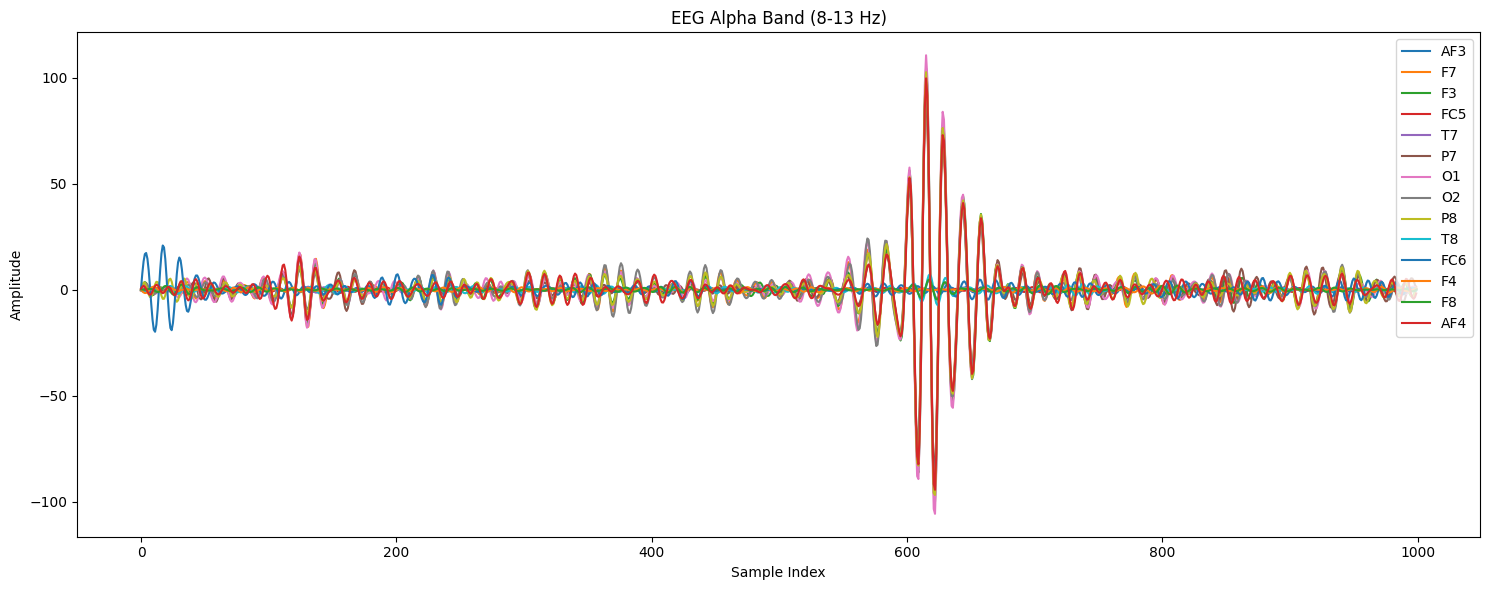

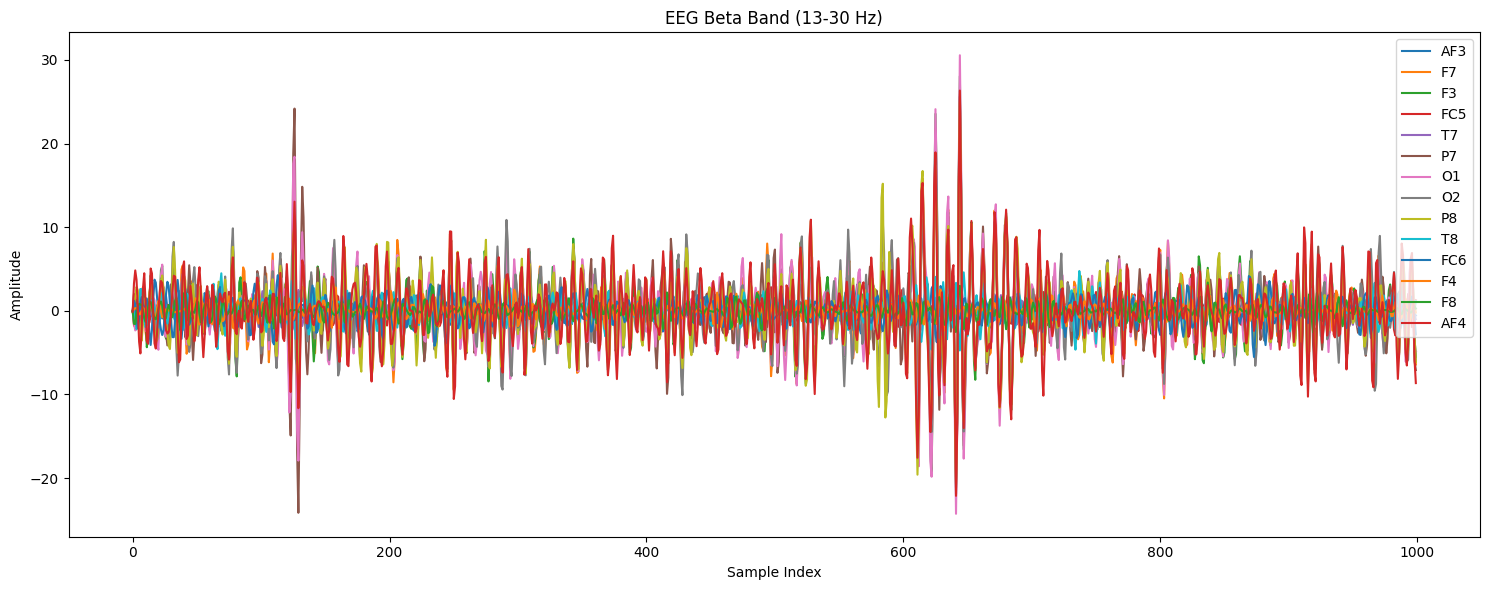

In [86]:
# BIỂU DIỄN TÍN HIỆU ALPHA VÀ BETA

# Lọc thông dải để giữ lại dải alpha (8-13 Hz) hoặc beta (13-30 Hz)
alpha_low = 8  # Hz
alpha_high = 13  # Hz
beta_low = 13  # Hz
beta_high = 30  # Hz

# Chọn dữ liệu từ file đầu tiên đã lọc để biểu diễn
filtered_0 = filtered_all_data[0]
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

alpha_band = bandpass_filter(filtered_0, alpha_low, alpha_high, sampFreq)
beta_band = bandpass_filter(filtered_0, beta_low, beta_high, sampFreq)

# Biểu diễn tín hiệu dải alpha
plt.figure(figsize=(15, 6))
plt.plot(alpha_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
plt.title('EEG Alpha Band (8-13 Hz)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(channel_names, loc='upper right')
plt.tight_layout()
plt.show()

# Biểu diễn tín hiệu dải beta
plt.figure(figsize=(15, 6))
plt.plot(beta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
plt.title('EEG Beta Band (13-30 Hz)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(channel_names, loc='upper right')
plt.tight_layout()
plt.show()

### 3. ICA

#### ICA with data original

ICA with 5 file đầu tiên (đại diện cho 1 người): giải thích output và chọn thành phần thì bàn sau

In [98]:
import mne
from mne.preprocessing import ICA

In [ ]:
# Gộp dữ liệu cho từng người và áp dụng ICA
ica_list = []
raw_list = []

for i in range(5):
    if i == 4:
        combined_data = np.concatenate(filtered_all_data[i * 7 : i * 7 + 6], axis=0)  # Người thứ 5 có 6 lần đo
    else:
        combined_data = np.concatenate(filtered_all_data[i * 7 : i * 7 + 7], axis=0)  # Người còn lại có 7 lần đo

    # Tạo thông tin cho đối tượng Raw
    sfreq = 128  # Tần số lấy mẫu (giả sử là 128 Hz, bạn có thể thay đổi nếu khác)
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')

    # Lấy dữ liệu đã lọc từ danh sách, chuyển đổi thành dạng phù hợp cho MNE
    filtered_data_mne = combined_data.T  # Chuyển thành (n_channels, n_times)

    # Tạo đối tượng Raw từ dữ liệu
    raw = mne.io.RawArray(filtered_data_mne, info)

    # Thêm montage vào đối tượng Raw với montage 'standard_1020'
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # Áp dụng ICA để tách các thành phần độc lập
    ica = ICA(n_components=14, random_state=42, max_iter='auto')
    ica.fit(raw)

    # Lưu ICA và Raw để sử dụng sau
    ica_list.append(ica)
    raw_list.append(raw)

    # In ra thông báo đã xử lý xong
    print(f'Đã áp dụng ICA cho dữ liệu của người thứ {i+1}')

Creating RawArray with float64 data, n_channels=14, n_times=2451228
    Range : 0 ... 2451227 =      0.000 ... 19150.211 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14644\1847376406.py:27: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 102.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 1
Creating RawArray with float64 data, n_channels=14, n_times=2602836
    Range : 0 ... 2602835 =      0.000 ... 20334.648 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14644\1847376406.py:27: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 124.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 2
Creating RawArray with float64 data, n_channels=14, n_times=2465676
    Range : 0 ... 2465675 =      0.000 ... 19263.086 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14644\1847376406.py:27: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 111.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 3
Creating RawArray with float64 data, n_channels=14, n_times=2414264
    Range : 0 ... 2414263 =      0.000 ... 18861.430 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14644\1847376406.py:27: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 172.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 4
Creating RawArray with float64 data, n_channels=14, n_times=2578548
    Range : 0 ... 2578547 =      0.000 ... 20144.898 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_14644\1847376406.py:27: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 190.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 5


Vẽ các thành phần ICA cho người thứ 1


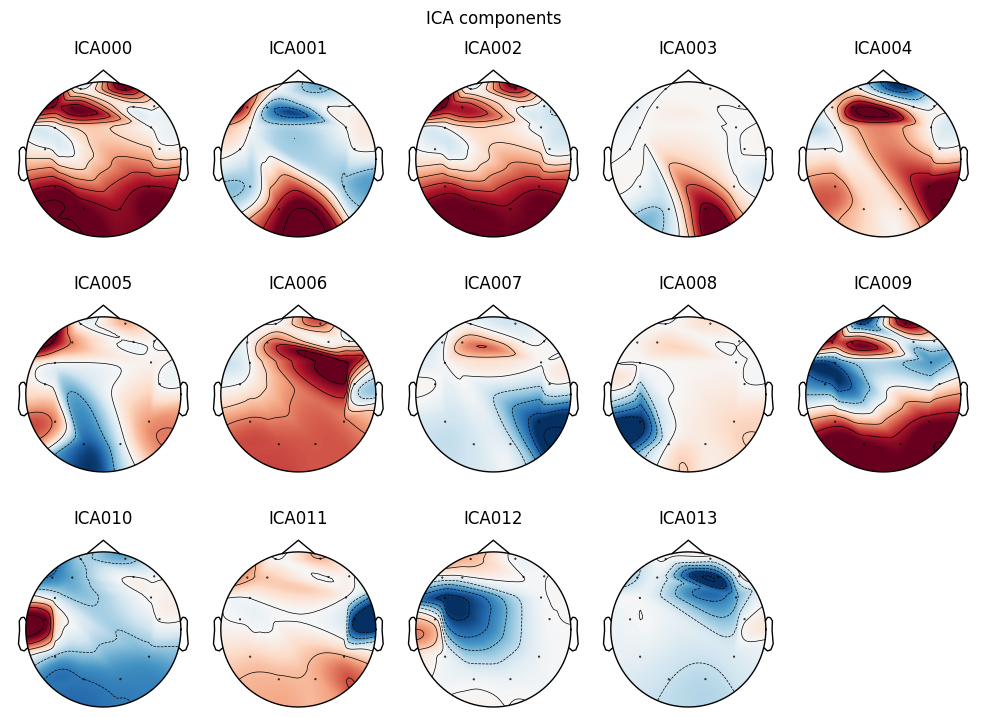

Creating RawArray with float64 data, n_channels=14, n_times=2451228
    Range : 0 ... 2451227 =      0.000 ... 19150.211 secs
Ready.


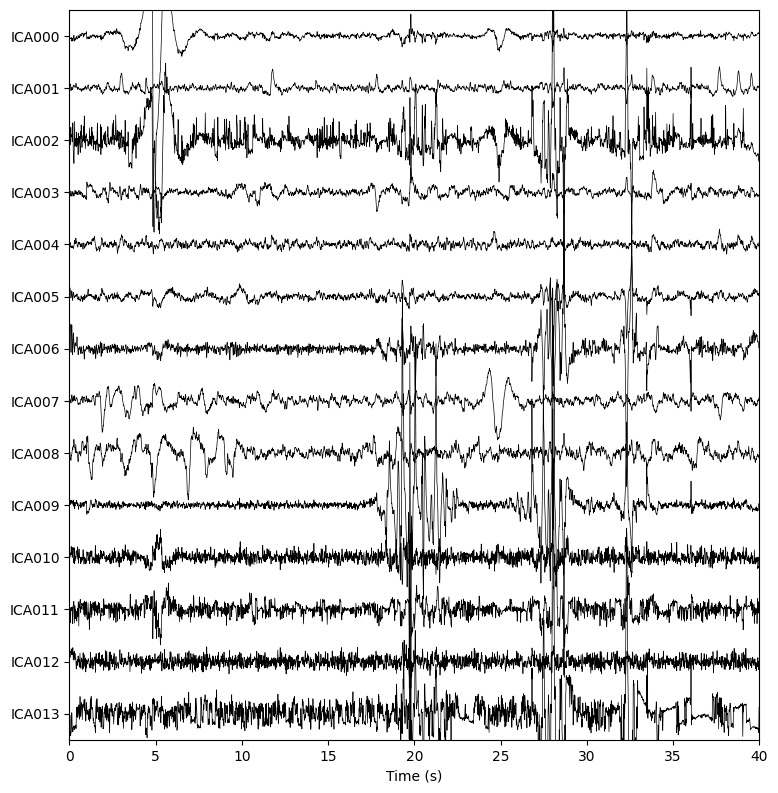

Vẽ các thành phần ICA cho người thứ 2


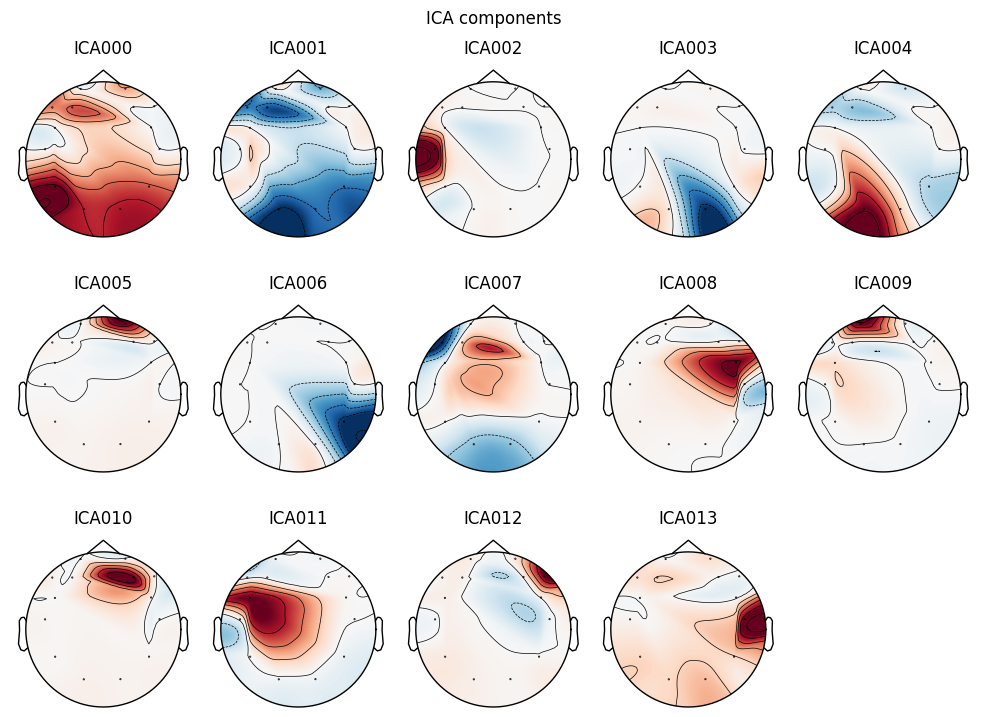

Creating RawArray with float64 data, n_channels=14, n_times=2602836
    Range : 0 ... 2602835 =      0.000 ... 20334.648 secs
Ready.


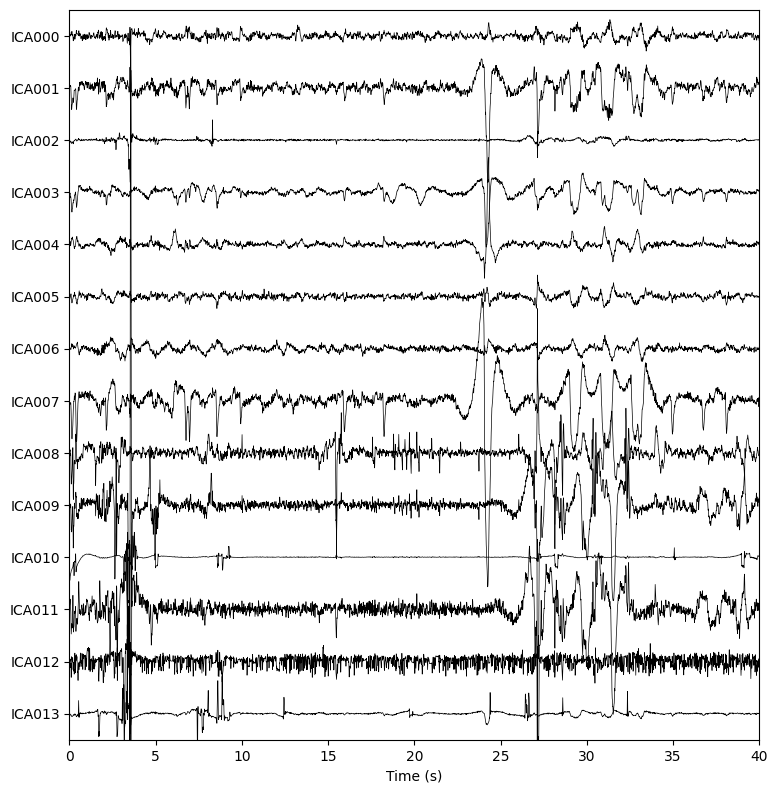

Vẽ các thành phần ICA cho người thứ 3


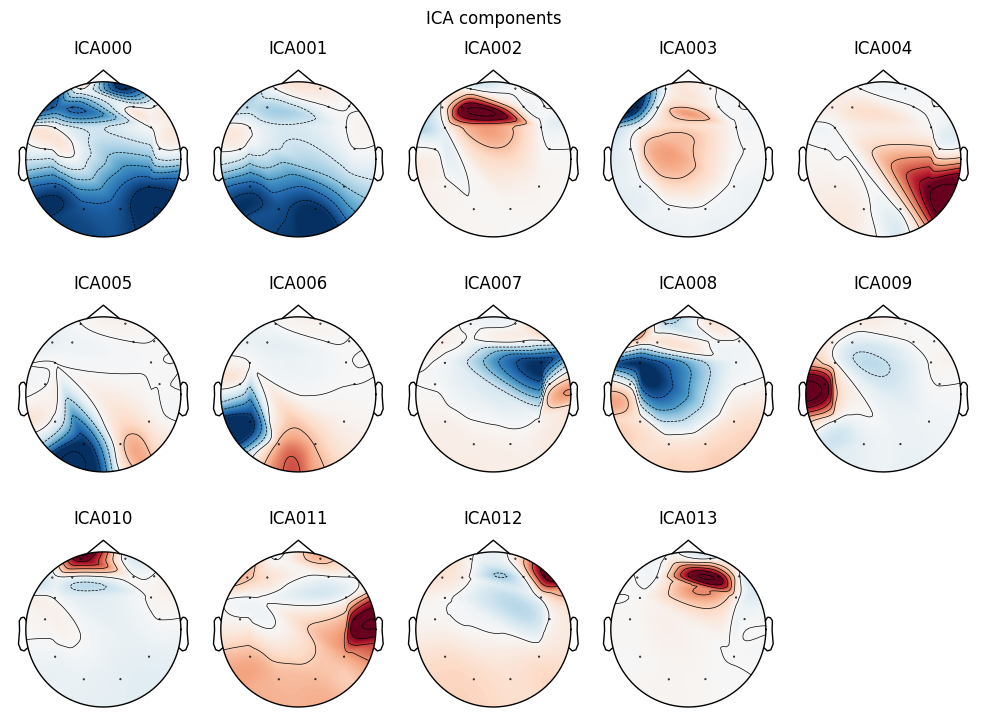

Creating RawArray with float64 data, n_channels=14, n_times=2465676
    Range : 0 ... 2465675 =      0.000 ... 19263.086 secs
Ready.


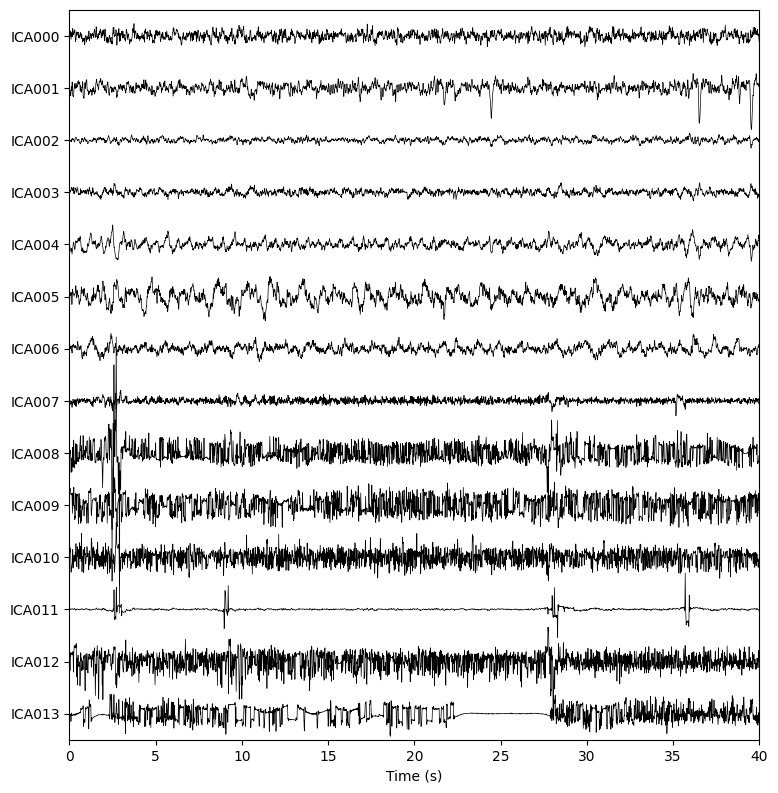

Vẽ các thành phần ICA cho người thứ 4


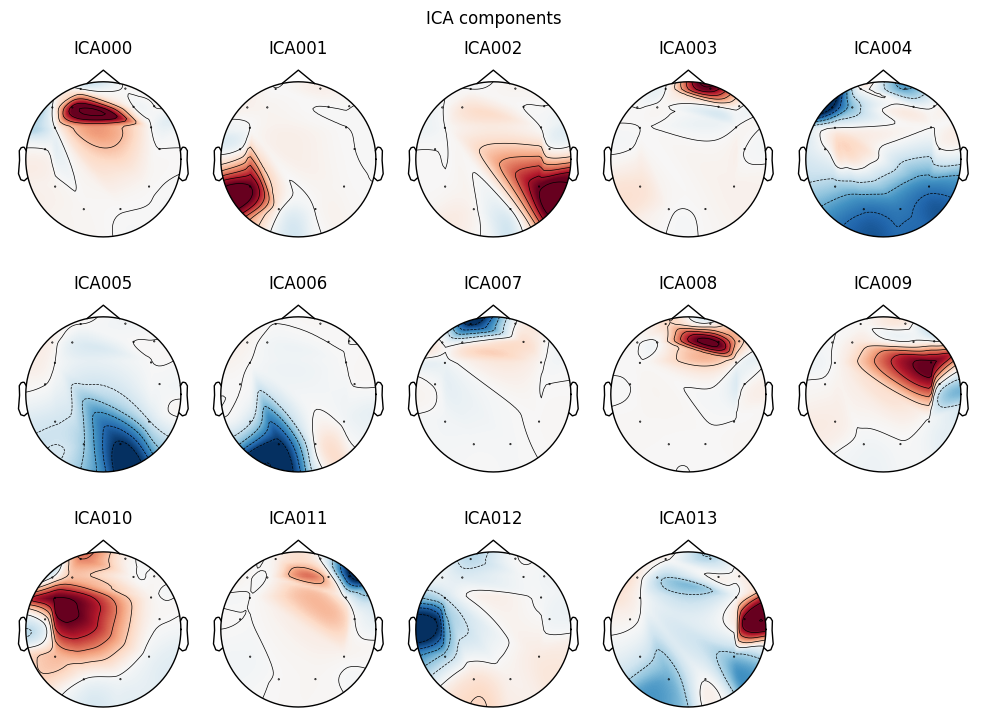

Creating RawArray with float64 data, n_channels=14, n_times=2414264
    Range : 0 ... 2414263 =      0.000 ... 18861.430 secs
Ready.


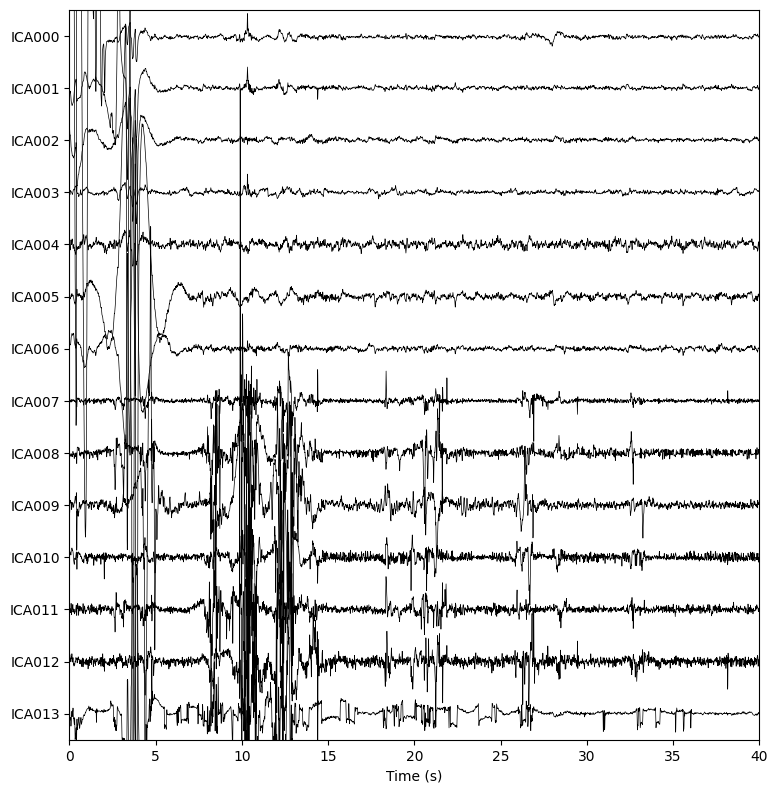

Vẽ các thành phần ICA cho người thứ 5


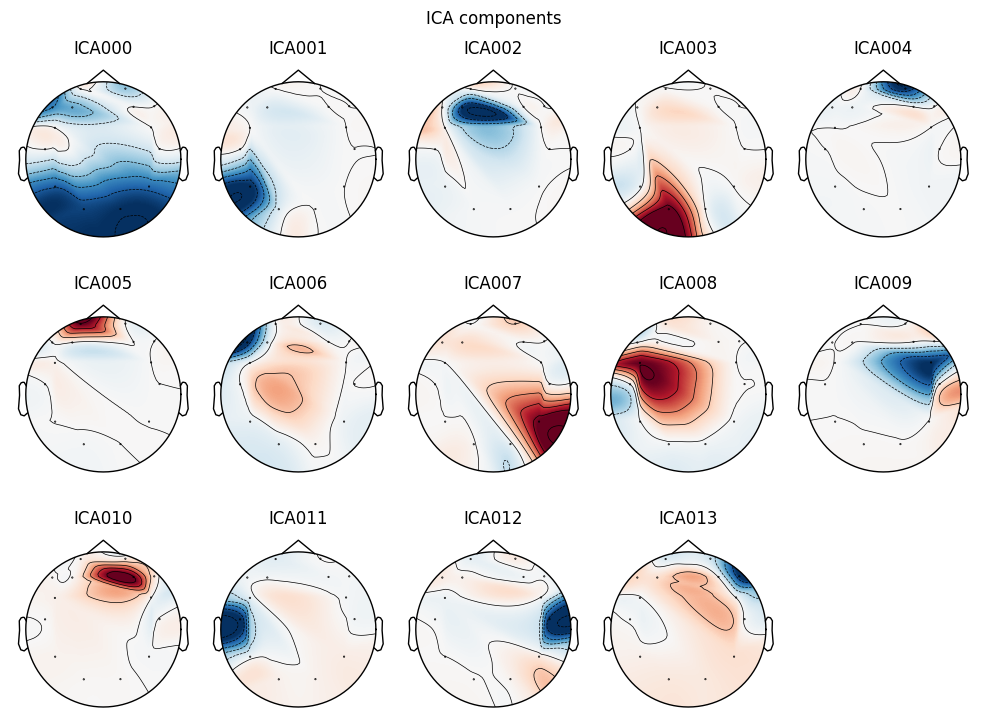

Creating RawArray with float64 data, n_channels=14, n_times=2578548
    Range : 0 ... 2578547 =      0.000 ... 20144.898 secs
Ready.


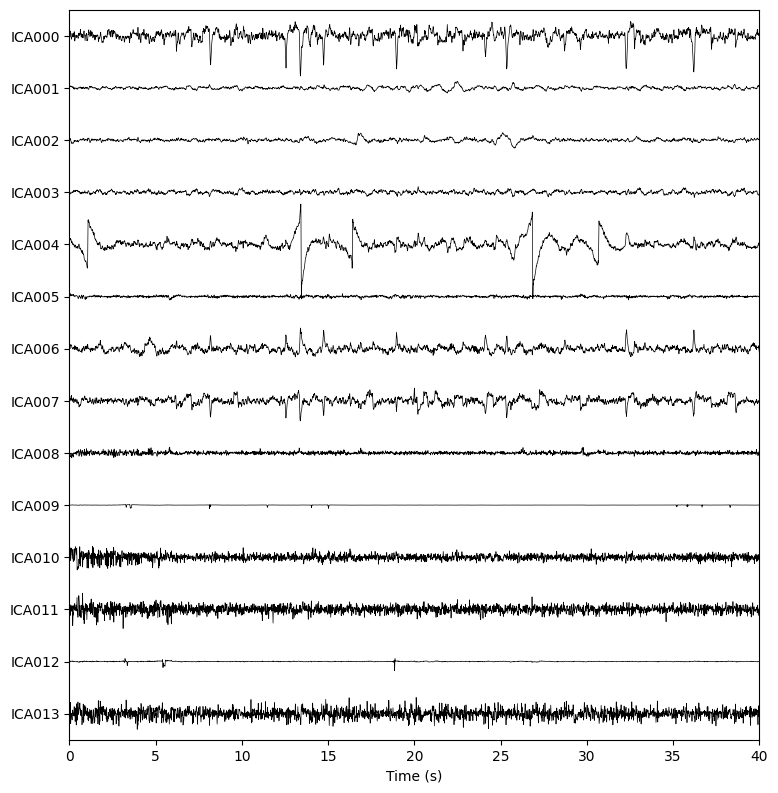

In [100]:
# Vẽ các thành phần độc lập cho từng người
for i, ica in enumerate(ica_list, start=0):
    print(f'Vẽ các thành phần ICA cho người thứ {i + 1}')
    ica.plot_components()
    ica.plot_sources(raw_list[i],start=0, stop=40, show_scrollbars=False)
    plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
9575 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9575 matching events found
No baseline correction applied
0 projection items activated


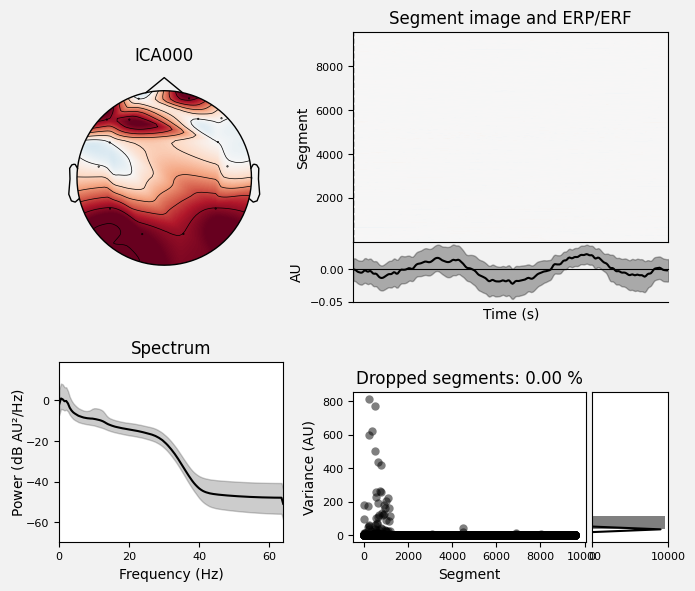

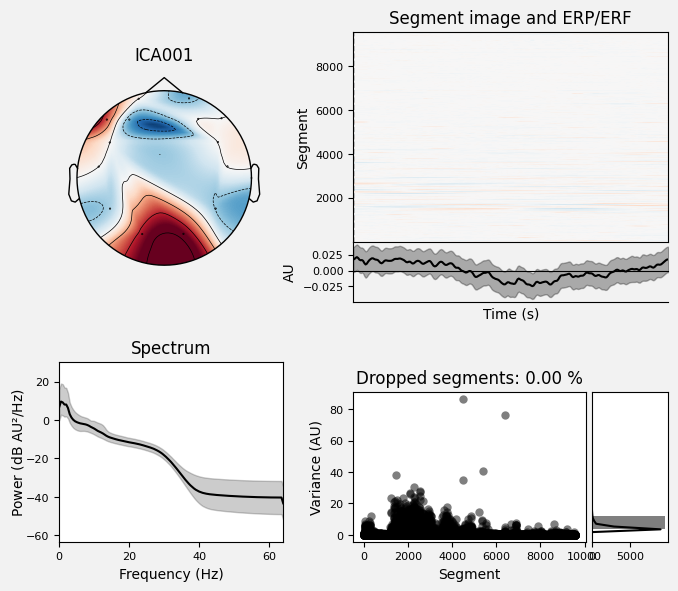

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [102]:
ica_list[0].plot_properties(raw_list[0], picks=[0, 1])

#### ICA loại bỏ nhiễu từ mắt, cơ và tim

In [ ]:
def detect_eog_artifacts(ica, raw, eye_channels):
    all_eog_indices = {}

    for ch in eye_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nháy mắt (EOG)
                eog_indices, _ = ica.find_bads_eog(raw, ch_name=ch)
                all_eog_indices[ch] = eog_indices
                # print(f"Các thành phần ICA liên quan đến nháy mắt với kênh {ch}: {eog_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_eog_indices

def detect_ecg_artifacts(ica, raw, heart_related_channels):
    all_ecg_indices = {}

    for ch in heart_related_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nhịp tim (ECG)
                ecg_indices, _ = ica.find_bads_ecg(raw, ch_name=ch)
                all_ecg_indices[ch] = ecg_indices
                # print(f"Các thành phần ICA liên quan đến nhịp tim với kênh {ch}: {ecg_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_ecg_indices

def print_indices_results(all_eog_indices, all_ecg_indices):
    # In kết quả EOG
    print("\nKết quả từ tất cả các kênh EOG:")
    for ch, indices in all_eog_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

    # In kết quả ECG
    print("\nKết quả từ tất cả các kênh ECG:")
    for ch, indices in all_ecg_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")


In [109]:
# LỌC NHIỄU TỪ MẮT TỪ CÁC KÊNH GẦN MẮT
eye_channels = ['AF3', 'AF4', 'F7', 'F8', 'F3', 'F4']

# Danh sách các kênh có thể bị ảnh hưởng bởi nhịp tim
heart_channels = ['FC5', 'FC6']

eog_indices = []
ecg_indices = []

for idx, raw in enumerate(raw_list):
    print(f"\nKết quả cho file #{idx + 1}:")
    eog = detect_eog_artifacts(ica_list[idx], raw_list[idx], eye_channels)
    ecg = detect_ecg_artifacts(ica_list[idx], raw_list[idx], heart_channels)

    eog_indices.append(eog)
    ecg_indices.append(ecg)


Kết quả cho file #1:
Using EOG channel: AF3
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff f

In [113]:
# In từng thành phần trong eog_indices
print("Các chỉ số ICA bị nhiễu mắt (EOG):")
for idx, eog in enumerate(eog_indices):
    print(f"File #{idx + 1} - Thành phần ICA EOG: {eog}\n")

# In từng thành phần trong ecg_indices
print("\nCác chỉ số ICA bị nhiễu tim (ECG):")
for idx, ecg in enumerate(ecg_indices):
    print(f"File #{idx + 1} - Thành phần ICA ECG: {ecg}")

Các chỉ số ICA bị nhiễu mắt (EOG):
File #1 - Thành phần ICA EOG: {'AF3': [9], 'AF4': [0], 'F7': [0], 'F8': [], 'F3': [0], 'F4': [13, 9]}

File #2 - Thành phần ICA EOG: {'AF3': [9, 12], 'AF4': [5], 'F7': [], 'F8': [12], 'F3': [], 'F4': [10]}

File #3 - Thành phần ICA EOG: {'AF3': [10, 8], 'AF4': [0], 'F7': [], 'F8': [12], 'F3': [2, 0], 'F4': [13]}

File #4 - Thành phần ICA EOG: {'AF3': [7], 'AF4': [3, 4], 'F7': [4, 1], 'F8': [11, 8], 'F3': [0], 'F4': [8]}

File #5 - Thành phần ICA EOG: {'AF3': [5], 'AF4': [4], 'F7': [], 'F8': [13, 10], 'F3': [2, 0], 'F4': [10]}


Các chỉ số ICA bị nhiễu tim (ECG):
File #1 - Thành phần ICA ECG: {'FC5': [], 'FC6': []}
File #2 - Thành phần ICA ECG: {'FC5': [], 'FC6': []}
File #3 - Thành phần ICA ECG: {'FC5': [], 'FC6': []}
File #4 - Thành phần ICA ECG: {'FC5': [], 'FC6': []}
File #5 - Thành phần ICA ECG: {'FC5': [], 'FC6': []}


In [143]:
def exclude_ica_components(ica, eog_indices, ecg_indices):
    # Lấy tất cả các chỉ số thành phần ICA từ EOG và ECG
    all_exclude_indices = []

    # Thêm các thành phần liên quan đến EOG vào danh sách loại trừ
    for eog in eog_indices.values():  # Duyệt qua các giá trị của dictionary
        all_exclude_indices.extend(eog)  # Các thành phần ICA liên quan đến EOG

    # Thêm các thành phần liên quan đến ECG vào danh sách loại trừ
    for ecg in ecg_indices.values():  # Duyệt qua các giá trị của dictionary
        all_exclude_indices.extend(ecg)  # Các thành phần ICA liên quan đến ECG

    # Loại bỏ các thành phần ICA tương ứng
    ica.exclude = list(set(all_exclude_indices))  # Loại bỏ trùng lặp
    print(f"Đã loại bỏ các thành phần ICA: {ica.exclude}")

# Ví dụ sử dụng với danh sách eog_indices và ecg_indices đã trích xuất
for idx, ica in enumerate(ica_list):
    print(f"\nĐang loại bỏ thành phần ICA cho file #{idx + 1}:")
    
    # Tạo bản sao của raw để giữ dữ liệu gốc và dữ liệu đã loại trừ riêng biệt
    raw_copy = raw_list[idx].copy()

    # Loại bỏ các thành phần ICA cho EOG và ECG
    exclude_ica_components(ica, eog_indices[idx], ecg_indices[idx])
    
    # Áp dụng ICA sau khi loại trừ
    ica.apply(raw_copy)  # Áp dụng loại trừ vào bản sao

    # Lưu raw_copy (dữ liệu đã loại trừ) và raw_list[idx] (dữ liệu gốc) nếu cần
    print(f"Đã loại trừ thành công cho file #{idx + 1}")



Đang loại bỏ thành phần ICA cho file #1:
Đã loại bỏ các thành phần ICA: [0, 9, 13]
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
Đã loại trừ thành công cho file #1

Đang loại bỏ thành phần ICA cho file #2:


KeyboardInterrupt: 